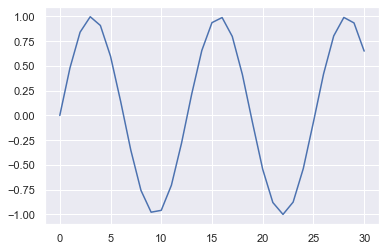

In [1]:
import pandas as pd
import numpy as np
import torch
np.random.seed(22)
import seaborn as sns
sns.set(color_codes=True)
x = np.linspace(0, 15, 31)
data = np.sin(x)
ax = sns.lineplot(data=data)

In [7]:
df = pd.read_csv("traffic_flow/crossroadNamev2.csv")
dlon = dict()
dlat = dict()
id_cood = dict()
for index, row in df.iterrows():
    dlon[row['crossroadID']] = row['lon']
    dlat[row['crossroadID']] = row['lat']
    id_cood[row['crossroadID']] = [row['lat'], row['lon']]
def lon_mapping(x):
    return dlon[x]
def lat_mapping(x):
    return dlat[x]

In [28]:
import time
from geopy.distance import geodesic
def load_traffic_data():
    data = pd.read_csv('traffic_flow/train.csv', index_col=0)
    
    # data = pd.read_csv('traffic_flow/train.csv')
#     data['lon'] = (data['lon'] - 120)* 1e2
#     data['lat'] = (data['lon'] - 32) * 1e2
#     data['day'] = data['timestamp'].apply(lambda x: time.strptime(x, "%Y/%m/%d %H:%M").tm_mday)
#     data['hour'] = data['timestamp'].apply(lambda x: time.strptime(x, "%Y/%m/%d %H:%M").tm_hour)
#     data['min'] = data['timestamp'].apply(lambda x: time.strptime(x, "%Y/%m/%d %H:%M").tm_min)
#     data['lon'] = data['crossroadID'].apply(lon_mapping)
#     data['lat'] = data['crossroadID'].apply(lat_mapping)
    seq = data.loc[:, ['direction', 'day', 'hour', 'min',  'flow']].values #   'lon', 'lat',
    seq = (seq - seq.min(axis=0)) / seq.max(axis=0)
    return data

     
def mktimestamp(dt):
    timeArray = time.strptime(dt, "%Y/%m/%d %H:%M")
    timestamp = time.mktime(timeArray)
    return int(timestamp)

def dist_mapping(x):
    return dist_dict[x]
data = pd.read_csv('traffic_flow/train.csv', index_col=0) #
day = 21
# data[data['crossroadID'] == 100002][data['direction'] == 1][data['day'] == 21]
cood = [dlat[100002], dlon[100002]]
dist_dict = dict()
for i in id_cood.keys():
    dist_dict[i] = geodesic(cood, id_cood[i]).km
sub_data = data.copy()
sub_data['dist'] = sub_data['crossroadID'].apply(dist_mapping)
ts = '2019/9/21 7:00'
sub_data[sub_data['timestamp'] == ts]

,crossroadID,direction,timestamp,flow,day,hour,min,lon,lat,dist
737936,100002,3,2019/9/21 7:00,35,21,7,0,120.383361,36.074286,0.000000
738080,100002,7,2019/9/21 7:00,5,21,7,0,120.383361,36.074286,0.000000
738212,100007,1,2019/9/21 7:00,31,21,7,0,120.385246,36.082750,0.954394
738356,100007,3,2019/9/21 7:00,19,21,7,0,120.385246,36.082750,0.954394
738500,100007,7,2019/9/21 7:00,65,21,7,0,120.385246,36.082750,0.954394
...,...,...,...,...,...,...,...,...,...,...
781373,100559,1,2019/9/21 7:00,23,21,7,0,120.344581,36.063640,3.687815
781517,100559,5,2019/9/21 7:00,16,21,7,0,120.344581,36.063640,3.687815
781661,100559,7,2019/9/21 7:00,18,21,7,0,120.344581,36.063640,3.687815
781805,100578,1,2019/9/21 7:00,7,21,7,0,120.345717,36.076171,3.397340


In [76]:
summit = pd.read_csv("traffic_flow/submit_example.csv")
road_list = list(set(summit['crossroadID'].values))

data = pd.read_csv('traffic_flow/trainv2.csv', index_col=0)
#
pro = 0
for it in range(len(road_list)):
    roadID = road_list[it]
    cood = id_cood[roadID]
    dist_dict = dict()
    for i in id_cood.keys():
        dist_dict[i] = geodesic(cood, id_cood[i]).km
    sub_data = data.copy()
    sub_data['dist'] = 1 / sub_data['crossroadID'].apply(dist_mapping) # # 取距离倒数作为初始权重 
    for index, row in summit[summit['crossroadID'] == roadID].iterrows():
        ts = summit.loc[index, 'timeBegin']
        sub_sum = sub_data[sub_data['timeBegin'] == ts]['dist'].sum()
        sub_data['weight'] = sub_data[sub_data['timeBegin'] == ts]['dist']  / sub_sum # 权重归一化 
        value = 0
        for nindex, row in sub_data[sub_data['timeBegin'] == ts].iterrows():
            value += sub_data.loc[nindex, 'flow'] * sub_data.loc[nindex, 'weight']
        summit.loc[index, 'value'] = value
        pro += 1
        print('Echo: %d / %d | roadID: %d | value: %.4f' % (pro, len(summit), roadID, value), end='\r')
summit

,date,crossroadID,direction,timeBegin,value
0,09-22,100003,1,7:30,64.715332
1,09-22,100003,1,7:35,67.324915
2,09-22,100003,1,7:40,66.248317
3,09-22,100003,1,7:45,71.403932
4,09-22,100003,1,7:50,71.421974
...,...,...,...,...,...
13963,09-25,100457,7,18:35,37.817647
13964,09-25,100457,7,18:40,36.568768
13965,09-25,100457,7,18:45,36.051611
13966,09-25,100457,7,18:50,35.099501


In [85]:
# summit['value'] = round(summit['value'], 1) * 3
# summit.to_csv('traffic_flow/submission.csv', index=0)
summit[summit['crossroadID']==100115]

,date,crossroadID,direction,timeBegin,value
1116,09-22,100115,1,7:30,185.7
1117,09-22,100115,1,7:35,187.2
1118,09-22,100115,1,7:40,189.0
1119,09-22,100115,1,7:45,197.1
1120,09-22,100115,1,7:50,194.1
...,...,...,...,...,...
11731,09-25,100115,7,18:35,181.2
11732,09-25,100115,7,18:40,176.4
11733,09-25,100115,7,18:45,176.1
11734,09-25,100115,7,18:50,171.0


In [35]:
data = pd.read_csv('traffic_flow/flow_data.csv')
data['date'] = data['timestamp'].apply(lambda x: '09-{}'.format(time.strptime(x, "%Y/%m/%d %H:%M").tm_mday))
data['timeBegin'] = data['timestamp'].apply(lambda x: '{}:{:2}'.format(time.strptime(x, "%Y/%m/%d %H:%M").tm_hour,
                                                                time.strptime(x, "%Y/%m/%d %H:%M").tm_min))
data['lon'] = data['crossroadID'].apply(lon_mapping)
data['lat'] = data['crossroadID'].apply(lat_mapping)
data.to_csv('traffic_flow/trainv2.csv', encoding='utf_8_sig')
# # data.to_csv('traffic_flow/train_with_nav2.csv', encoding='utf_8_sig')
# # a = data[data['crossroadID'] == 100002][data['direction'] == 1][data['hour'] == 14]
# # # ax = sns.lineplot(data=a)
# #data['time'] = 0
# #
# # data.to_csv('traffic_flow/train_with_na.csv', encoding='utf_8_sig')
# ld = len(data)
# for index, row in data.iterrows():
#     if index == 0 and data.loc[index, 'flow'] == 0:
#         i = 0
#         while i < ld:
#             if data.loc[i, 'flow']:
#                 data.loc[index, 'flow'] = data.loc[i, 'flow']
#                 break
#             else:
#                 i += 1
#                 if i % 100 == 0:
#                     print(i)
#     elif data.loc[index, 'flow'] == 0:
#         data.loc[index, 'flow'] = data.loc[index-1, 'flow']
#     if index % 100 == 0:
#         print('Epoch: {:6} / {:8}'.format(index, ld), end='\r')
# data.to_csv('traffic_flow/train_with_nav2.csv', encoding='utf_8_sig')

# ld = len(data)
# for index, row in data.iterrows():
#     if data.loc[index, 'flow'] == 0:
#         try:
#             i = 1
#             while i < 1000:
#                 if data.loc[index+i, 'flow'] == 0:
#                     i += 1
#                 else:
#                     break
#             data.loc[index, 'flow'] = (data.loc[index-1, 'flow'] + data.loc[index+i, 'flow']) / 2
#         except Exception as e:
#             data.loc[index, 'flow'] = (data.loc[index-1, 'flow'] + data.loc[index-2, 'flow']) / 2
#             print('exception occured in %d\t\t\t\t\t' % index, end='\r')
#     if index % 100 == 0:
#         print('Epoch: {:6} / {:8}\t\t\t\t\t'.format(index, ld), end='\r')
# data.to_csv('traffic_flow/train_with_nav3.csv', encoding='utf_8_sig')

In [12]:
def test():
    data = pd.read_csv('traffic_flow/train.csv', index_col=0)
    a = data[data['crossroadID'] == 100002][data['direction'] == 1].loc[:, ['day', 'hour', 'min', 'flow']]
    a['hour'] = a['hour'] + a['min'] / 60 - 7
    seq = a.loc[:, ['flow', 'day', 'hour']].values
    seq = (seq - seq.min(axis=0)) / seq.max(axis=0)
    return seq
# data = pd.read_csv('traffic_flow/train.csv', index_col=0)
# len(data[data['crossroadID'] == 100033][data['direction']==1].loc[:, ['day', 'hour', 'min', 'flow']])
data = pd.read_csv('traffic_flow/train_with_na.csv', index_col=0)
a = data[data['crossroadID'] == 100033][data['direction']==1].loc[:, ['day', 'hour', 'min', 'flow']]
a

C:\Users\Shinelon\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\env\miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,day,hour,min,flow
2863,1,7,0,27
2864,1,7,5,50
2865,1,7,10,30
2866,1,7,15,36
2867,1,7,20,34
...,...,...,...,...
1048556,16,12,40,0
1048560,14,10,25,0
1048564,2,16,35,0
1048568,4,8,15,0


In [13]:
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    """
    PyCharm Crtl+click nn.LSTM() jump to code of PyTorch:
    Examples::
        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

def load_data():
    # passengers number of international airline , 1949-01 ~ 1960-12 per month
    seq_number = np.array(
        [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
         209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
         272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
         302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
         315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
         318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
         348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
         362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
         342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
         417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
         432.], dtype=np.float32)
    # assert seq_number.shape == (144, )
    # plt.plot(seq_number)
    # plt.ion()
    # plt.pause(1)
    seq_number = seq_number[:, np.newaxis]

    # print(repr(seq))
    # 1949~1960, 12 years, 12*12==144 month
    seq_year = np.arange(12)
    seq_month = np.arange(12)
    seq_year_month = np.transpose(
        [np.repeat(seq_year, len(seq_month)),
         np.tile(seq_month, len(seq_year))],
    )  # Cartesian Product

    seq = np.concatenate((seq_number, seq_year_month), axis=1)

    # normalization
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)
    return seq
load_data()

array([[-1.40777884, -1.59325501, -1.59325501],
       [-1.35759023, -1.59325501, -1.30357228],
       [-1.24048348, -1.59325501, -1.01388955],
       [-1.26557778, -1.59325501, -0.72420682],
       [-1.33249593, -1.59325501, -0.43452409],
       [-1.21538918, -1.59325501, -0.14484136],
       [-1.10664719, -1.59325501,  0.14484136],
       [-1.10664719, -1.59325501,  0.43452409],
       [-1.20702441, -1.59325501,  0.72420682],
       [-1.34922546, -1.59325501,  1.01388955],
       [-1.47469699, -1.59325501,  1.30357228],
       [-1.35759023, -1.59325501,  1.59325501],
       [-1.38268454, -1.30357228, -1.59325501],
       [-1.29067209, -1.30357228, -1.30357228],
       [-1.16520057, -1.30357228, -1.01388955],
       [-1.21538918, -1.30357228, -0.72420682],
       [-1.29903686, -1.30357228, -0.43452409],
       [-1.09828242, -1.30357228, -0.14484136],
       [-0.9226223 , -1.30357228,  0.14484136],
       [-0.9226223 , -1.30357228,  0.43452409],
       [-1.02299951, -1.30357228,  0.724

C:\env\miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Training Start
Save in: ./net.pth 0.00105
L1: 0.362    L2: 0.195
-0.4978163083060778


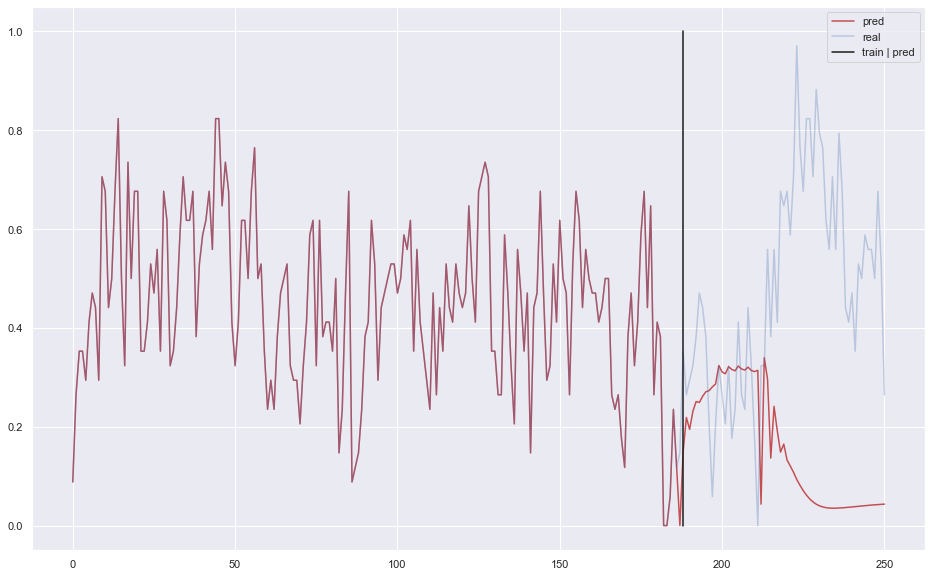

In [15]:
from sklearn.metrics import r2_score
inp_dim = 3
out_dim = 1
mid_dim = 8
mid_layers = 1
batch_size = 12 * 4
mod_dir = '.'

'''load data'''
data = test()
data_x = data[:-1, :]
data_y = data[+1:, 0]
assert data_x.shape[1] == inp_dim

train_size = int(len(data_x) * 0.75)

train_x = data_x[:train_size]
train_y = data_y[:train_size]
train_x = train_x.reshape((train_size, inp_dim))
train_y = train_y.reshape((train_size, out_dim))

'''build model'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

'''train'''
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for i in range(batch_size):
    j = train_size - i
    batch_var_x.append(var_x[j:])
    batch_var_y.append(var_y[j:])

from torch.nn.utils.rnn import pad_sequence
batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

print("Training Start")
for e in range(1920):
    out = net(batch_var_x)

    # loss = criterion(out, batch_var_y)
    loss = (out - batch_var_y) ** 2 * weights
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()), end='\r')
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

'''eval'''
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()

test_x = data_x.copy()
test_x[train_size:, 0] = 0
test_x = test_x[:, np.newaxis, :]
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

'''simple way but no elegant'''
# for i in range(train_size, len(data)-2):
#     test_y = net(test_x[:i])
#     test_x[i, 0, 0] = test_y[-1]

'''elegant way but slightly complicated'''
eval_size = 1
zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
test_x[train_size + 1, 0, 0] = test_y[-1]
for i in range(train_size + 1, len(data) - 2):
    test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
    test_x[i + 1, 0, 0] = test_y[-1]
pred_y = test_x[1:, 0, 0]
pred_y = pred_y.cpu().data.numpy()
pred_y = np.append(pred_y, net(test_x[:])[-1].cpu().detach())

diff_y = pred_y[train_size:] - data_y[train_size:]
l1_loss = np.mean(np.abs(diff_y))
l2_loss = np.mean(diff_y ** 2)
print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))
print(r2_score(data_y, pred_y))

plt.figure(figsize=(16, 10))
plt.plot(pred_y, 'r', label='pred')
plt.plot(data_y, 'b', label='real', alpha=0.3)
plt.plot([train_size, train_size], [0, 1], color='k', label='train | pred')
plt.legend(loc='best')
plt.savefig('lstm_reg.png')
plt.pause(4)

In [200]:
test_x, data_y

(tensor([[[0.1969, 0.0000, 0.0000]],
 
         [[0.3780, 0.0000, 0.0070]],
 
         [[0.2205, 0.0000, 0.0140]],
 
         ...,
 
         [[0.3480, 0.9600, 0.9371]],
 
         [[0.3798, 0.9600, 0.9441]],
 
         [[0.3818, 0.9600, 0.9510]]], device='cuda:0', grad_fn=<CopySlices>),
 array([0.37795276, 0.22047244, 0.26771654, ..., 0.30708661, 0.30708661,
        0.34645669]))

In [123]:
def run_train_lstm():
    loss_fn = torch.nn.MSELoss(reduction='sum')
    inp_dim = 4
    out_dim = 1
    mid_dim = 12
    mid_layers = 1
    batch_size = 12 * 4
    mod_dir = '.'

    '''load data'''
    data = load_traffic_data()
    data_x = data[:-1, :]
    data_y = data[+1:, 0]
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.7)

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

    batch_var_x = list()
    batch_var_y = list()

    for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

    print("Training Start")
    for e in range(384):
        out = net(batch_var_x)
    
        # loss = criterion(out, batch_var_y)
        loss = loss_fn(out, batch_var_y)
#         loss = (out - batch_var_y) ** 2 * weights
#         loss = loss.mean()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if e % 8 == 0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()), end='\r')
#     torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
#     print("Save in:", '{}/net.pth'.format(mod_dir))

#     '''eval'''
#     net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
#     net = net.eval()

    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

#     '''simple way but no elegant'''
#     for i in range(train_size, len(data) - 2):
#         test_y = net(test_x[:i])
#         test_x[i, 0, 0] = test_y[-1]
    '''elegant way but slightly complicated'''
    eval_size = 1
    zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
    test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
    test_x[train_size + 1, 0, 0] = test_y[-1]
    for i in range(train_size + 1, len(data) - 2):
        test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
        test_x[i + 1, 0, 0] = test_y[-1]
        print('Process: {} / {}\p\p'.format(i, len(data)), end='\r')
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
    l1_loss = np.mean(np.abs(diff_y))
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

#     plt.plot(pred_y, 'r', label='pred')
#     plt.plot(data_y, 'b', label='real', alpha=0.3)
#     plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
#     plt.legend(loc='best')
#     plt.savefig('lstm_reg.png')
#     plt.pause(4)


In [45]:
run_train_lstm()

Training Start
L1: 1.015    L2: 1.4952878563


In [126]:
loss_fn = torch.nn.MSELoss(reduction='mean')
inp_dim = 5
out_dim = 1
mid_dim = 12
mid_layers = 1
batch_size = 12 * 4
mod_dir = '.'

'''load data'''
data = load_traffic_data()
data_x = data[:-1, :]
data_y = data[+1:, 0]
assert data_x.shape[1] == inp_dim

train_size = int(len(data_x) * 0.7)

train_x = data_x[:train_size]
train_y = data_y[:train_size]
train_x = train_x.reshape((train_size, inp_dim))
train_y = train_y.reshape((train_size, out_dim))

'''build model'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

'''train'''
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for i in range(batch_size):
    j = train_size - i
    batch_var_x.append(var_x[j:])
    batch_var_y.append(var_y[j:])

from torch.nn.utils.rnn import pad_sequence
batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

print("Training Start")
for e in range(384):
    out = net(batch_var_x)

    # loss = criterion(out, batch_var_y)
    loss = loss_fn(out, batch_var_y)
#         loss = (out - batch_var_y) ** 2 * weights
#         loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 8 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()), end='\r')

test_x = data_x.copy()
test_x[train_size:, 0] = 0
test_x = test_x[:, np.newaxis, :]
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

'''elegant way but slightly complicated'''
eval_size = 1
zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
test_x[train_size + 1, 0, 0] = test_y[-1]
for i in range(train_size + 1, len(data) - 2):
    test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
    test_x[i + 1, 0, 0] = test_y[-1]
    print('Process: {} / {}\t\t'.format(i, len(data)), end='\r')
pred_y = test_x[1:, 0, 0]
pred_y = pred_y.cpu().data.numpy()

diff_y = pred_y[train_size:] - data_y[train_size:-1]
l1_loss = np.mean(np.abs(diff_y))
l2_loss = np.mean(diff_y ** 2)
print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

Training Start
L1: 0.424    L2: 0.25928		


In [132]:
from sklearn.metrics import r2_score
r2_score(data_y[train_size:-1], pred_y[train_size:])

-2.254160788656131

In [109]:
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F


# 自定义一个Net类，继承于torch.nn.Module类
# 这个神经网络的设计是只有一层隐含层，隐含层神经元个数可随意指定
class Net(torch.nn.Module):
    # Net类的初始化函数
    def __init__(self, n_feature, n_hidden, n_output):
        # 继承父类的初始化函数
        super(Net, self).__init__()
        # 网络的隐藏层创建，名称可以随便起
        self.hidden_layer = torch.nn.Linear(n_feature, n_hidden)
        # 输出层(预测层)创建，接收来自隐含层的数据
        self.predict_layer = torch.nn.Linear(n_hidden, n_output)

    # 网络的前向传播函数，构造计算图
    def forward(self, x):
        # 用relu函数处理隐含层输出的结果并传给输出层
        hidden_result = self.hidden_layer(x)
        relu_result = F.relu(hidden_result)
        predict_result = self.predict_layer(relu_result)
        return predict_result

# 训练次数
TRAIN_TIMES = 1000
# 输入输出的数据维度，这里都是1维
INPUT_FEATURE_DIM = 5
OUTPUT_FEATURE_DIM = 1
# 隐含层中神经元的个数
NEURON_NUM = 32
# 学习率，越大学的越快，但也容易造成不稳定，准确率上下波动的情况
LEARNING_RATE = 0.1

In [110]:
'''load data'''
data = load_traffic_data()
data_x = data[:, :-1]
data_y = data[:, -1]
# assert data_x.shape[1] == inp_dim

train_size = int(len(data_x) * 0.7)

train_x = data_x[:train_size]
train_y = data_y[:train_size]
train_x = train_x.reshape((train_size, INPUT_FEATURE_DIM))
train_y = train_y.reshape((train_size, 1))

'''build model'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

'''train'''
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

# 建立网络
net = Net(n_feature=INPUT_FEATURE_DIM, n_hidden=NEURON_NUM, n_output=OUTPUT_FEATURE_DIM).to(device)

# 训练网络
# 这里也可以使用其它的优化方法
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
# 定义一个误差计算方法
loss_func = torch.nn.MSELoss(reduction='mean')

for i in range(TRAIN_TIMES):
    # 输入数据进行预测
    prediction = net(var_x)
    # 计算预测值与真值误差，注意参数顺序问题
    # 第一个参数为预测值，第二个为真值
    loss = loss_func(prediction, var_y)

    # 开始优化步骤
    # 每次开始优化前将梯度置为0
    optimizer.zero_grad()
    # 误差反向传播
    loss.backward()
    # 按照最小loss优化参数
    optimizer.step()
    if i % 10 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(i, loss.item()), end='\r')

In [111]:
test_size = len(data_x) - train_size
test_x = data_x[train_size:]
test_y = data_y[train_size:]
test_x = test_x.reshape((test_size, INPUT_FEATURE_DIM))
test_y = test_y.reshape((test_size, 1))
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
test_y = torch.tensor(test_y, dtype=torch.float32, device=device)

In [116]:
prediction = net(test_x)
loss = loss_func(prediction, test_y)
loss.item()

0.010754669085144997

In [117]:
test_x

tensor(0.0991, device='cuda:0')

In [114]:
prediction

tensor([[0.1015],
        [0.1015],
        [0.1015],
        ...,
        [0.1015],
        [0.1015],
        [0.1015]], device='cuda:0', grad_fn=<AddmmBackward>)

In [118]:
r2_score(test_y.cpu().detach().numpy(), prediction.cpu().detach().numpy())

-0.0005288418886173485